# Twitter sentiment analysis using NLP

**The purpose of this project is to examine the dependencies between the situation in Afghanistan and tweets concerned Biden and Trump in August 2021 based on NLP techniques.**

## Table of contents

<div class="toc">
	<ul class="toc-item">
		<li>
			<span>
				<a href="#1.-Scraping-tweets" data-toc-modified-id="1.-Scraping-tweets">
					<span class="toc-item-num">1.&nbsp;&nbsp;</span>Scraping tweets
				</a>
			</span>
		</li>
		<li>
			<span>
				<a href="#2.-Cleaning-data" data-toc-modified-id="2.-Cleaning-data">
					<span class="toc-item-num">2.&nbsp;&nbsp;</span>Cleaning data
				</a>
			</span>
		</li>
		<li>
			<span>
				<a href="#3.-Joining-data-since-27.08.2021" data-toc-modified-id="3.-Joining-data-since-27.08.2021">
					<span class="toc-item-num">3.&nbsp;&nbsp;</span>Joining data since 27.08.2021
				</a>
			</span>
		</li>
		<li>
			<span>
				<a href="#4.-Sentiment-analysis---polarity-&-subjectivity" data-toc-modified-id="4.-Sentiment-analysis---polarity-&-subjectivity">
					<span class="toc-item-num">4.&nbsp;&nbsp;</span>Sentiment analysis - polarity & subjectivity
				</a>
			</span>
		</li>
        <li>
			<span>
				<a href="#5.-Tweets-languages" data-toc-modified-id="5.-Tweets-languages">
					<span class="toc-item-num">5.&nbsp;&nbsp;</span>Tweets languages
				</a>
			</span>
			<ul class="toc-item">
				<li>
					<span>
						<a href="#5.1.-English" data-toc-modified-id="5.1.-English">
							<span class="toc-item-num">5.1&nbsp;&nbsp;</span>English
						</a>
					</span>
				</li>
                <li>
					<span>
						<a href="#5.2.-Spanish" data-toc-modified-id="5.2.-Spanish">
							<span class="toc-item-num">5.2&nbsp;&nbsp;</span>Spanish
						</a>
					</span>
				</li>
                <li>
					<span>
						<a href="#5.3.-German" data-toc-modified-id="5.3.-German">
							<span class="toc-item-num">5.3&nbsp;&nbsp;</span>German
						</a>
					</span>
				</li>
                <li>
					<span>
						<a href="#5.4.-French" data-toc-modified-id="5.4.-French">
							<span class="toc-item-num">5.4&nbsp;&nbsp;</span>French
						</a>
					</span>
				</li>
                <li>
					<span>
						<a href="#5.5.-Polish" data-toc-modified-id="5.5.-Polish">
							<span class="toc-item-num">5.5&nbsp;&nbsp;</span>Polish
						</a>
					</span>
				</li>
			</ul>
		</li>
        <li>
			<span>
				<a href="#6.-Polarity-&-Subjectivity---plots" data-toc-modified-id="6.-Polarity-&-Subjectivity---plots">
					<span class="toc-item-num">6.&nbsp;&nbsp;</span>Polarity & Subjectivity - plots
				</a>
			</span>
		</li>
	</ul>
</div>

In [1]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
import numpy as np
from datetime import datetime
import re
import string
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from langdetect import detect
from google_trans_new import google_translator
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
pd.options.display.max_rows = 100

**Versions:**

1. pandas == 1.2.4
2. numpy == 1.19.5
3. re == 2.2.1
4. nltk == 3.6.2
5. matplotlib == 3.3.4
6. textblob == 0.15.3
7. sklearn == 0.24.2
8. wordcloud == 1.8.1
9. google_trans_new == 1.1.9
10. snscrape == 0.3.4
11. langdetect == 1.0.9
12. string
13. datetime
14. pandas_profiling == 3.0.0

In [1108]:
#print('\n'.join(f'{m.__name__} == {m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

## 1. Scraping tweets

Due to the date on which I started this project (27.08.2021) and the period which I would like to examine (since 01.08.2021), I had to use a library that allows scraping historical tweets. I decided to use *snscrape*. I noticed that the number of tweets scraping that way (using that library) is significantly smaller than the number of tweets scraped on an ongoing basis (another library). However, after checking several options, I was under the impression that my choices were severely restricted. So I gave *snscrape* a chance while being aware of limitations - bias and variance.

In [2]:
biden_tweets = []

for i,tweet in enumerate(sntwitter.TwitterSearchScraper('#Biden since:2021-08-01 until:2021-08-27').get_items()):
    if i > 1_000_000:
        break
    biden_tweets.append([tweet.date, tweet.content])
   
biden = pd.DataFrame(biden_tweets, columns = ['Datetime', 'Text'])

In [3]:
#biden.to_csv("Biden.csv", encoding = 'utf-8', index=False)

In [4]:
trump_tweets = []

for i,tweet in enumerate(sntwitter.TwitterSearchScraper('#Trump since:2021-08-01 until:2021-08-27').get_items()):
    if i > 1_000_000:
        break
    trump_tweets.append([tweet.date, tweet.content])
   
trump = pd.DataFrame(trump_tweets, columns = ['Datetime', 'Text'])

In [5]:
#trump.to_csv("Trump.csv", encoding = 'utf-8', index=False)

## 2. Cleaning data

The next step was cleaning the data. Unexpectedly, the Biden dataset included erroneously scraped data (the dates were not the dates), and some rows caused problems later for both Biden and Trump dataset so that rows were deleted from the initial datasets. The rest of the rows were cleaned by removing emojis, http(s) addresses, punctuation marks. The texts were reduced to lower case and joined hashtags (#KabulAiport) were divided (kabul airport).

In [6]:
d_parser = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S%z')

biden = pd.read_csv("Biden.csv", sep = ',', engine = 'python')
trump = pd.read_csv("Trump.csv", sep = ',', engine='python', parse_dates = ['Datetime'], date_parser = d_parser)

In [7]:
duplicateRowsDF = biden[biden.duplicated()]
second_rows = duplicateRowsDF.index
first_rows = second_rows-1
all_rows = second_rows.append(first_rows)

biden = biden.drop([10223, 10224, 33518, 33519, 34884, 45540, 51911,
                    56054, 60112, 66129, 66734, 83760, 97736, 108435]).drop(all_rows).reset_index()
biden["Datetime"] = pd.to_datetime(biden["Datetime"], format = '%Y-%m-%d %H:%M:%S%z')

trump = trump.drop([31488]).reset_index()

In [8]:
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

def clean_text(text):
    text = re.sub('(https?:\/\/[\w\d\.\/]*)', '', text)              # http(s) addresses
    text = re.sub('[\.,\?!⁉️‼@#⁉️\(\):;&‘’/“”…-'']', '', text)         # punctuation
    text = re.sub(r'([A-Z][a-z]+|([a-z] A)[A-Z])', r'\1 ', text)     # divide hashtags             
    text = text.lower()
    text = re.sub('\w*\d\w*', '', text)                              # delete words with digits 
    text = re.sub('\n', ' ', text)
    text = emoji_pattern.sub(r'', text)
    text = re.sub("[%s]" % re.escape(string.punctuation), '', text)  # punctuation
    return text

clean = lambda x: clean_text(x)

In [9]:
biden_clean = pd.DataFrame(biden['Text'].apply(clean))
biden_clean['Datetime'] = biden['Datetime']

trump_clean = pd.DataFrame(trump['Text'].apply(clean))
trump_clean['Datetime'] = trump['Datetime']

The first two cleaned rows for Biden and Trump datasets:

In [10]:
for i in range(0,2):
    print("-------------------------------------------------- BIDEN original --------------------------------------------------\n\n", 
          biden['Text'][i],
          "\n\n-------------------------------------------------- BIDEN cleaned --------------------------------------------------\n\n",
          biden_clean['Text'][i], "\n")
    print("-------------------------------------------------- TRUMP original --------------------------------------------------\n\n",
          trump['Text'][i],
          "\n\n-------------------------------------------------- TRUMP cleaned --------------------------------------------------\n\n",
          trump_clean['Text'][i], "\n")

-------------------------------------------------- BIDEN original --------------------------------------------------

 Saw the Biden speech.. Is US in the midst of a massive PR ‘Spin’ exercise to salvage humongous loss of reputation by changing the narrative??! Hmmm!
#KabulAiport #WagTheDog #ChangeTheNarrative 
#Biden #Afghanishtan #Kabul 

-------------------------------------------------- BIDEN cleaned --------------------------------------------------

 saw  the biden  speech is  us in the midst of a massive pr spin  exercise to salvage humongous loss of reputation by changing the narrative hmmm  kabul aiport  wag the dog  change the narrative   biden  afghanishtan  kabul  

-------------------------------------------------- TRUMP original --------------------------------------------------

 Where’s Our Real President: #DonaldJTrump @Potus45 ??

#Trump Won Election Handedly. 

@DNC @SpeakerPelosi #BiasedMSM &amp; Fixed #Dominion Voting Machines Cheated &amp; Placed @JoeBiden @Kamala

Then the rows were examined by detecting language for each row.

In [11]:
biden_clean["Language"] = 'NA'
biden_clean["Translation"] = 'NA'

trump_clean["Language"] = 'NA'
trump_clean["Translation"] = 'NA'

In [79]:
for i in range(0, len(biden_clean)):
    language = detect(biden_clean['Text'][i])
    biden_clean['Language'][i] = language

In [78]:
for i in range(0, len(trump_clean)):
    language = detect(trump_clean['Text'][i])
    trump_clean['Language'][i] = language

In [125]:
#biden_clean.to_csv("Biden_clean.csv", encoding = 'utf-8', index=False)
#trump_clean.to_csv("Trump_clean.csv", encoding = 'utf-8', index=False)

## 3. Joining data since 27.08.2021

As a consequence of scraping the data in the middle of the month, the rest of the days (from 27.08.2021 until 01.09.2021) were joined to the original datasets.

In [2]:
biden_clean = pd.read_csv("Biden_clean.csv", sep = ',', engine = 'python')
trump_clean = pd.read_csv("Trump_clean.csv", sep = ',', engine = 'python')

biden_clean["Datetime"] = pd.to_datetime(biden_clean["Datetime"], format = '%Y-%m-%d %H:%M:%S%z')
trump_clean["Datetime"] = pd.to_datetime(trump_clean["Datetime"], format = '%Y-%m-%d %H:%M:%S%z')

In [3]:
biden_clean_since_27 = pd.read_csv("Biden_clean_since_27_08_2021.csv", sep = ',', engine = 'python')
trump_clean_since_27 = pd.read_csv("Trump_clean_since_27_08_2021.csv", sep = ',', engine = 'python')

biden_clean_since_27["Datetime"] = pd.to_datetime(biden_clean_since_27["Datetime"], format = '%Y-%m-%d %H:%M:%S%z')
trump_clean_since_27["Datetime"] = pd.to_datetime(trump_clean_since_27["Datetime"], format = '%Y-%m-%d %H:%M:%S%z')

In [4]:
biden_clean = biden_clean_since_27.append(biden_clean, ignore_index = True, sort = False)
trump_clean = trump_clean_since_27.append(trump_clean, ignore_index = True, sort = False)

## 4. Sentiment analysis - polarity & subjectivity

For calculating *polarity* and *subjectivity*, *TextBlob* library was used. However, the library is prepared to be called only for English texts. As a consequence, the non-English tweets had to be translated priorly.

In [145]:
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

## 5. Tweets languages

Due to the quite massive numbers of tweets in datasets, I decided to translate only a few of the most popular + Polish as my native language. Amid the most common, English took 1st place, Italian 2nd and Spanish or German 3rd. Taking into account mistakes which are made by used *language detector* and similarity between Italian and Spanish, I chose English (tremendous share), Spanish, German, French (Europe languages, similar, but noticeably different) and Polish (native language + curiosity).

The following language's analysis is based on determining *polarity* and *subjectivity*, and if needed also on prior translation. Analysis was extended by *Word Clouds* for English and Polish.

In [1104]:
biden_l = biden_clean['Language'].value_counts()
trump_l = trump_clean['Language'].value_counts()
print('Biden top 6 languages acc. to no. of tweets:\n')
print(biden_l[:6])
print('\nTrump top 6 languages acc. to no. of tweets:\n')
print(trump_l[:6])

Biden top 6 languages acc. to no. of tweets:

en    101483
it      8306
es      6453
nl      6219
fr      4688
de      3338
Name: Language, dtype: int64

Trump top 6 languages acc. to no. of tweets:

en    77528
it     2497
de     2482
es     2354
fr     2269
ro     1777
Name: Language, dtype: int64


## 5.1. English

In [494]:
biden_en = biden_clean[biden_clean['Language'].isin(["en"])]
trump_en = trump_clean[trump_clean['Language'].isin(["en"])]

print("ENGLISH tweets in Biden's tweets: ", len(biden_en)/len(biden_clean),
      "\nENGLISH tweets in Trump's tweets: ", len(trump_en)/len(trump_clean))

ENGLISH tweets in Biden's tweets:  0.6989861281390768 
ENGLISH tweets in Trump's tweets:  0.8087796532370799


In [496]:
biden_en.loc[:, "Polarity"] = biden_en['Text'].apply(pol)
biden_en.loc[:, "Subjectivity"] = biden_en['Text'].apply(sub)

trump_en.loc[:, "Polarity"] = trump_en['Text'].apply(pol)
trump_en.loc[:, "Subjectivity"] = trump_en['Text'].apply(sub)

### Biden profile

In [6]:
profile = ProfileReport(biden_en, title="Biden English Tweets | Pandas Profiling Report", 
                        missing_diagrams=None, duplicates=None)
profile.to_widgets()

Summarize dataset:   0%|          | 0/19 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

### Trump profile

In [7]:
profile = ProfileReport(trump_en, title="Trump English Tweets | Pandas Profiling Report", 
                        missing_diagrams=None, duplicates=None)
profile.to_widgets()

Summarize dataset:   0%|          | 0/19 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [497]:
#biden_en.to_csv("Biden_en.csv", encoding = 'utf-8', index = False)
#trump_en.to_csv("Trump_en.csv", encoding = 'utf-8', index = False)

In [2]:
d_parser = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S%z')

biden_en = pd.read_csv("Biden_en.csv", sep = ',', engine = 'python', parse_dates = ['Datetime'], date_parser = d_parser)
trump_en = pd.read_csv("Trump_en.csv", sep = ',', engine = 'python', parse_dates = ['Datetime'], date_parser = d_parser)

biden_en.set_index('Datetime', inplace = True)
trump_en.set_index('Datetime', inplace = True)

To create a *Word Cloud*, there is the necessity to determine the most popular words and their frequencies. To make *clouds* more meaningful, it is also a good practice to remove common words (called *stop words*).

In [3]:
biden_text = biden_en['Text'].str.cat(sep = ' ')
trump_text = trump_en['Text'].str.cat(sep = ' ')

president = [biden_text, trump_text]
tweets = []

for i in president:
    cv_president = CountVectorizer(stop_words = "english")
    input = [i]
    president_cv = cv_president.fit_transform(input)
    row = pd.DataFrame(president_cv.toarray(), columns = cv_president.get_feature_names())
    tweets.append(row)

president = []
    
for i in tweets:
    president.append(i)

tweets = pd.concat(president, sort = True)
tweets = tweets.set_axis(["Biden", "Trump"])
tweets = tweets.replace(np.nan, 0)
tweets = tweets.astype(int)

In [4]:
tweets

aa  aaa  aaaaaaaaaahhh  aaaaaaattt  aaaaand  aaaand  aaaannd  aaand  \
Biden  16    4              0           1        2       4        0      2   
Trump  16    3              1           0        1       3        1      0   

       aaaye  aabbasi  ...  𝙛𝙞𝙧𝙢𝙡𝙮  𝙛𝙧𝙤𝙢  𝙝𝙚  𝙢𝙚𝙙𝙞𝙖  𝙤𝙣  𝙥𝙧𝙤𝙗𝙡𝙚𝙢  𝙨𝙤𝙘𝙞𝙖𝙡  \
Biden      1        0  ...       0     1   1      1   1        1       1   
Trump      0        1  ...       1     0   0      0   0        0       0   

       𝙩𝙚𝙖𝙢  𝙩𝙪𝙧𝙣𝙨  𝙫𝙖𝙘𝙖𝙩𝙞𝙤𝙣  
Biden     1      1         1  
Trump     0      0         0  

[2 rows x 101814 columns]

In [5]:
tweets = tweets.transpose()

I was not fully satisfied with the quality of determining stop words, so based on *biden_dict* and *trump_dict*, I added my own. Grabbed words sorted descending according to a number of occurrences were printed below.

In [6]:
tokens_with_sw = (["didnt", "time", "going", "just", "years", "say", "like", "doesnt", "really", "did",
                  "gop", "maga", "right", "dont", "news", "people", "twitter", "today", "don", "day",
                  "says", "im", "think", "know", "does", "let", "speech", "want", "story", "big",
                  "better", "man", "women", "wrong", "bidens", "trumps", "cnn", "media", "country", "radio",
                  "rally", "trying", "make", "house", "days", "hands", "cuomo", "thing", "look", "good", "guy",
                  "world", "way", "said", "family", "stop", "great", "real", "new", "press", "amp"])

In [7]:
biden_dict = {}

top = tweets["Biden"].sort_values(ascending=False)
biden_dict = dict(zip(top.index.tolist(), top.values))

delete = tokens_with_sw

for i in range(0, len(delete)):
    if delete[i] in biden_dict:
        del biden_dict[delete[i]]
    
#biden_dict
dict(list(biden_dict.items())[:10])

{'biden': 143106,
 'afghanistan': 37219,
 'trump': 21452,
 'taliban': 17993,
 'joe': 11517,
 'kabul': 11183,
 'president': 10198,
 'america': 8393,
 'usa': 7285,
 'potus': 6794}

In [8]:
trump_dict = {}

top = tweets["Trump"].sort_values(ascending=False)
trump_dict = dict(zip(top.index.tolist(), top.values))

delete = tokens_with_sw

for i in range(0, len(delete)):
    if delete[i] in trump_dict:
        del trump_dict[delete[i]]
    
#trump_dict
dict(list(trump_dict.items())[:10])

{'trump': 98669,
 'biden': 27296,
 'afghanistan': 11835,
 'taliban': 11613,
 'president': 6541,
 'america': 6357,
 'usa': 5420,
 'joe': 5279,
 'donald': 4326,
 'republicans': 4212}

Amid the most popular words, in addition to "biden" or "trump", there were also terms related to Afghanistan like: "taliban", "afghan", "afghanistan", "kabul" or "airport". Some words were not connected with current political situation at all (e.g. "border", "covid", "vaccine") and some were ambiguous: "help", "disaster", "left", "failure". In both *word clouds*, the words "biden" and "trump" occurred often.

In [505]:
wc = WordCloud(background_color = "white", colormap = "Dark2", width = 800, height = 400, max_words = 200)

plt.rcParams['figure.figsize'] = [32, 12]

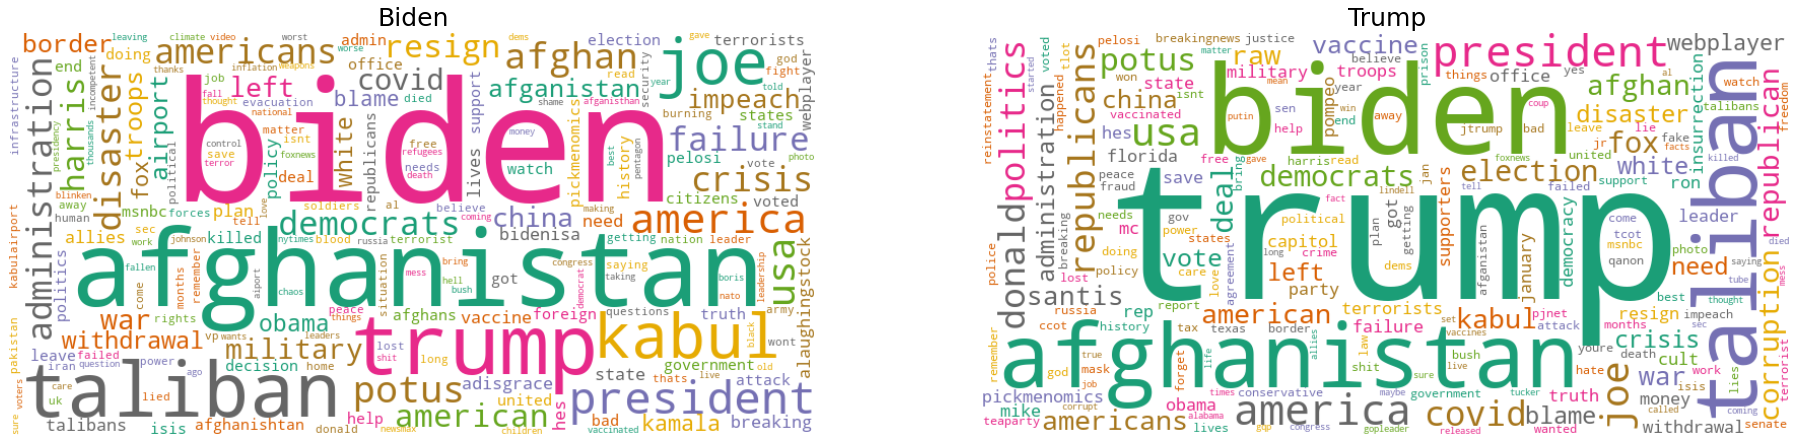

In [506]:
president = {"president": ["Biden", "Trump"], 
        "text": [biden_en, trump_en]}
presidents = [biden_dict, trump_dict]

for index in range(0, len(presidents)):
    
    wc.generate_from_frequencies(presidents[index])
    plt.subplot(1, 2, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(president['president'][index], fontsize=25)
    
plt.show()

## 5.2. Spanish

The following 3 analyses were done similarly - translation - polarity and subjectivity and presidents' profiles. So I am not going to focus on that.

In [519]:
biden_es = biden_clean[biden_clean['Language'].isin(["es"])]
biden_es = biden_es.reset_index()
biden_es = biden_es.drop(['index'], axis = 1)

trump_es = trump_clean[trump_clean['Language'].isin(["es"])]
trump_es = trump_es.reset_index()
trump_es = trump_es.drop(['index'], axis = 1)

print("SPANISH tweets in Biden's tweets: ", len(biden_es)/len(biden_clean),
      "\nSPANISH tweets in Trump's tweets: ", len(trump_es)/len(trump_clean))

SPANISH tweets in Biden's tweets:  0.044446434229195655 
SPANISH tweets in Trump's tweets:  0.024557157462079326


In [661]:
tweets_translations = []
for i in range(0, len(biden_es)):
    tweets_translations.append(google_translator().translate(biden_es['Text'][i], lang_tgt='en'))

translations_biden = pd.DataFrame(tweets_translations)
biden_es['Translation'] = translations_biden.values

tweets_translations = []
for i in range(0, len(trump_es)):
    tweets_translations.append(google_translator().translate(trump_es['Text'][i], lang_tgt='en'))

translations_trump = pd.DataFrame(tweets_translations)
trump_es['Translation'] = translations_trump.values

In [663]:
biden_es.loc[:, "Polarity"] = biden_es['Translation'].apply(pol)
biden_es.loc[:, "Subjectivity"] = biden_es['Translation'].apply(sub)

trump_es.loc[:, "Polarity"] = trump_es['Translation'].apply(pol)
trump_es.loc[:, "Subjectivity"] = trump_es['Translation'].apply(sub)

### Biden profile

In [9]:
profile = ProfileReport(biden_es, title="Biden Spanish Tweets | Pandas Profiling Report", 
                        missing_diagrams=None, duplicates=None)
profile.to_widgets()

Summarize dataset:   0%|          | 0/19 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

### Trump profile

In [10]:
profile = ProfileReport(trump_es, title="Trump Spanish Tweets | Pandas Profiling Report", 
                        missing_diagrams=None, duplicates=None)
profile.to_widgets()

Summarize dataset:   0%|          | 0/19 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [664]:
#biden_es.to_csv("Biden_es.csv", encoding = 'utf-8', index = False)
#trump_es.to_csv("Trump_es.csv", encoding = 'utf-8', index = False)

In [8]:
d_parser = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S%z')

biden_es = pd.read_csv("Biden_es.csv", sep = ',', engine = 'python', parse_dates = ['Datetime'], date_parser = d_parser)
trump_es = pd.read_csv("Trump_es.csv", sep = ',', engine = 'python', parse_dates = ['Datetime'], date_parser = d_parser)

biden_es.set_index('Datetime', inplace = True)
trump_es.set_index('Datetime', inplace = True)

## 5.3. German

In [684]:
biden_de = biden_clean[biden_clean['Language'].isin(["de"])]
biden_de = biden_de.reset_index()
biden_de = biden_de.drop(['index'], axis = 1)

trump_de = trump_clean[trump_clean['Language'].isin(["de"])]
trump_de = trump_de.reset_index()
trump_de = trump_de.drop(['index'], axis = 1)

print("GERMAN tweets in Biden's tweets: ", len(biden_de)/len(biden_clean),
      "\nGERMAN tweets in Trump's tweets: ", len(trump_de)/len(trump_clean))

GERMAN tweets in Biden's tweets:  0.022991197498381386 
GERMAN tweets in Trump's tweets:  0.025892465939201737


In [689]:
tweets_translations = []
for i in range(0, len(biden_de)):
    tweets_translations.append(google_translator().translate(biden_de['Text'][i], lang_tgt='en'))

translations_biden = pd.DataFrame(tweets_translations)
biden_de['Translation'] = translations_biden.values

tweets_translations = []
for i in range(0, len(trump_de)):
    tweets_translations.append(google_translator().translate(trump_de['Text'][i], lang_tgt='en'))

translations_trump = pd.DataFrame(tweets_translations)
trump_de['Translation'] = translations_trump.values

In [688]:
biden_de.loc[:, "Polarity"] = biden_de['Translation'].apply(pol)
biden_de.loc[:, "Subjectivity"] = biden_de['Translation'].apply(sub)

trump_de.loc[:, "Polarity"] = trump_de['Translation'].apply(pol)
trump_de.loc[:, "Subjectivity"] = trump_de['Translation'].apply(sub)

### Biden profile

In [13]:
profile = ProfileReport(biden_de, title="Biden German Tweets | Pandas Profiling Report", 
                        missing_diagrams=None, duplicates=None)
profile.to_widgets()

Summarize dataset:   0%|          | 0/19 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

### Trump profile

In [12]:
profile = ProfileReport(trump_de, title="Trump German Tweets | Pandas Profiling Report", 
                        missing_diagrams=None, duplicates=None)
profile.to_widgets()

Summarize dataset:   0%|          | 0/19 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [690]:
#biden_de.to_csv("Biden_de.csv", encoding = 'utf-8', index = False)
#trump_de.to_csv("Trump_de.csv", encoding = 'utf-8', index = False)

In [11]:
d_parser = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S%z')

biden_de = pd.read_csv("Biden_de.csv", sep = ',', engine = 'python', parse_dates = ['Datetime'], date_parser = d_parser)
trump_de = pd.read_csv("Trump_de.csv", sep = ',', engine = 'python', parse_dates = ['Datetime'], date_parser = d_parser)

biden_de.set_index('Datetime', inplace = True)
trump_de.set_index('Datetime', inplace = True)

## 5.4. French

In [698]:
biden_fr = biden_clean[biden_clean['Language'].isin(["fr"])]
biden_fr = biden_fr.reset_index()
biden_fr = biden_fr.drop(['index'], axis = 1)

trump_fr = trump_clean[trump_clean['Language'].isin(["fr"])]
trump_fr = trump_fr.reset_index()
trump_fr = trump_fr.drop(['index'], axis = 1)

print("FRENCH tweets in Biden's tweets: ", len(biden_fr)/len(biden_clean),
      "\nFRENCH tweets in Trump's tweets: ", len(trump_fr)/len(trump_clean))

FRENCH tweets in Biden's tweets:  0.032289614701141986 
FRENCH tweets in Trump's tweets:  0.023670429176490225


In [700]:
tweets_translations = []
for i in range(0, len(biden_fr)):
    tweets_translations.append(google_translator().translate(biden_fr['Text'][i], lang_tgt='en'))

translations_biden = pd.DataFrame(tweets_translations)
biden_fr['Translation'] = translations_biden.values

tweets_translations = []
for i in range(0, len(trump_fr)):
    tweets_translations.append(google_translator().translate(trump_fr['Text'][i], lang_tgt='en'))

translations_trump = pd.DataFrame(tweets_translations)
trump_fr['Translation'] = translations_trump.values

In [701]:
biden_fr.loc[:, "Polarity"] = biden_fr['Translation'].apply(pol)
biden_fr.loc[:, "Subjectivity"] = biden_fr['Translation'].apply(sub)

trump_fr.loc[:, "Polarity"] = trump_fr['Translation'].apply(pol)
trump_fr.loc[:, "Subjectivity"] = trump_fr['Translation'].apply(sub)

### Biden profile

In [15]:
profile = ProfileReport(biden_fr, title="Biden French Tweets | Pandas Profiling Report", 
                        missing_diagrams=None, duplicates=None)
profile.to_widgets()

Summarize dataset:   0%|          | 0/19 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

### Trump profile

In [16]:
profile = ProfileReport(biden_fr, title="Trump French Tweets | Pandas Profiling Report", 
                        missing_diagrams=None, duplicates=None)
profile.to_widgets()

Summarize dataset:   0%|          | 0/19 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [702]:
#biden_fr.to_csv("Biden_fr.csv", encoding = 'utf-8', index = False)
#trump_fr.to_csv("Trump_fr.csv", encoding = 'utf-8', index = False)

In [14]:
d_parser = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S%z')

biden_fr = pd.read_csv("Biden_fr.csv", sep = ',', engine = 'python', parse_dates = ['Datetime'], date_parser = d_parser)
trump_fr = pd.read_csv("Trump_fr.csv", sep = ',', engine = 'python', parse_dates = ['Datetime'], date_parser = d_parser)

biden_fr.set_index('Datetime', inplace = True)
trump_fr.set_index('Datetime', inplace = True)

## 5.5. Polish

For the Polish language, steps similar to the English language have been taken.

In [222]:
biden_pl = biden_clean[biden_clean['Language'].isin(["pl"])]
biden_pl = biden_pl.reset_index()
biden_pl = biden_pl.drop(['index'], axis = 1)

trump_pl = trump_clean[trump_clean['Language'].isin(["pl"])]
trump_pl = trump_pl.reset_index()
trump_pl = trump_pl.drop(['index'], axis = 1)

print("POLISH tweets in Biden's tweets: ", len(biden_pl)/len(biden_clean),
      "\nPOLISH tweets in Trump's tweets: ", len(trump_pl)/len(trump_clean))

POLISH tweets in Biden's tweets:  0.0042497210474839175 
POLISH tweets in Trump's tweets:  0.0023576540299192557


In [241]:
tweets_translations = []
for i in range(0, len(biden_pl)):
    tweets_translations.append(google_translator().translate(biden_pl['Text'][i], lang_tgt='en'))

translations_biden = pd.DataFrame(tweets_translations)
biden_pl['Translation'] = translations_biden.values

tweets_translations = []
for i in range(0, len(trump_pl)):
    tweets_translations.append(google_translator().translate(trump_pl['Text'][i], lang_tgt='en'))
    
translations_trump = pd.DataFrame(tweets_translations)
trump_pl['Translation'] = translations_trump.values

In [228]:
biden_pl.loc[:, "Polarity"] = biden_pl['Translation'].apply(pol)
biden_pl.loc[:, "Subjectivity"] = biden_pl['Translation'].apply(sub)

trump_pl.loc[:, "Polarity"] = trump_pl['Translation'].apply(pol)
trump_pl.loc[:, "Subjectivity"] = trump_pl['Translation'].apply(sub)

### Biden profile

In [99]:
profile = ProfileReport(biden_pl, title="Biden Polish Tweets | Pandas Profiling Report", 
                        missing_diagrams=None, duplicates=None)
profile.to_widgets()

Summarize dataset:   0%|          | 0/19 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

### Trump profile

In [100]:
profile = ProfileReport(biden_pl, title="Trump Polish Tweets | Pandas Profiling Report", 
                        missing_diagrams=None, duplicates=None)
profile.to_widgets()

Summarize dataset:   0%|          | 0/19 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [231]:
#biden_pl.to_csv("Biden_pl.csv", encoding = 'utf-8', index = False)
#trump_pl.to_csv("Trump_pl.csv", encoding = 'utf-8', index = False)

In [9]:
d_parser = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S%z')

biden_pl = pd.read_csv("Biden_pl.csv", sep = ',', engine = 'python', parse_dates = ['Datetime'], date_parser = d_parser)
trump_pl = pd.read_csv("Trump_pl.csv", sep = ',', engine = 'python', parse_dates = ['Datetime'], date_parser = d_parser)

biden_pl.set_index('Datetime', inplace = True)
trump_pl.set_index('Datetime', inplace = True)

In [10]:
biden_text = biden_pl['Text'].str.cat(sep = ' ')
trump_text = trump_pl['Text'].str.cat(sep = ' ')

president = [biden_text, trump_text]
tweets = []

for i in president:
    cv_president = CountVectorizer()
    input = [i]
    president_cv = cv_president.fit_transform(input)
    row = pd.DataFrame(president_cv.toarray(), columns = cv_president.get_feature_names())
    tweets.append(row)

president = []
    
for i in tweets:
    president.append(i)

tweets = pd.concat(president, sort = True)
tweets = tweets.set_axis(["Biden", "Trump"])
tweets = tweets.replace(np.nan, 0)
tweets = tweets.astype(int)

In [11]:
tweets

aaa  ab  abc  abdula  aborcji  aborcję  abrams  absolutnie  aby  \
Biden    1   3    0       0        1        1       2           2    9   
Trump    0   0    1       1        0        0       0           0    2   

       acosta  ...  żydów  żyje  żyjemy  żykistanu  żyliście  żywego  żywo  \
Biden       0  ...      1     2       1          1         1       1     5   
Trump       1  ...      0     0       0          0         0       0     2   

       żyć  żył  żyłbiden  
Biden    1    1         1  
Trump    0    0         0  

[2 rows x 5783 columns]

In [12]:
tweets = tweets.transpose()

In [13]:
tokens_with_sw = (["nie", "to", "na", "się", "że", "do", "jest", "co", "za", "jak",
                  "ma", "po", "już", "tak", "czy", "od", "tego", "tym", "dla", "ale",
                  "przez", "będzie", "tylko", "teraz", "jego", "ów", "bo", "też", "są", "by",
                  "było", "ze", "chcą", "niż", "nord", "stream", "być", "więcej", "nawet", "będą",
                  "on", "mówi", "bez", "lat", "nas", "nigdy", "sobie", "niech", "świat", "ich", "bia",
                  "nadal", "której", "ńczycy", "wszystkich", "nic", "sprawie", "jeśli", "tam", "gdzie", "gdy", 
                  "media", "przed", "jeszcze", "ten", "pod", "mu", "pytanie", "cały", "może", "czyli",
                  "był", "jednak", "bardzo", "wsch", "który", "pierwsz", "ta", "is", "bliski", "czasy",
                  "si", "us", "można", "no", "powiedział", "mnie", "jaki", "pl", "ód", "twierdzi", "the",
                  "twitter", "gdybyby", "były", "now", "ły", "jego", "wszystko", "jako", "gdyby", "we", "wi",
                  "które", "zrobić", "podjeli", "kto", "powinni", "świecie", "aby", "byla", "właśnie", "mam",
                  "tych", "mówił", "podjął", "wiadomosci", "bweglarczyk"])

In [14]:
biden_dict = {}

top = tweets["Biden"].sort_values(ascending=False)
biden_dict = dict(zip(top.index.tolist(), top.values))

delete = tokens_with_sw

for i in range(0, len(delete)):
    if delete[i] in biden_dict:
        del biden_dict[delete[i]]
    
#biden_dict
dict(list(biden_dict.items())[:10])

{'biden': 637,
 'usa': 197,
 'afganistan': 149,
 'joe': 102,
 'kabul': 72,
 'bidena': 69,
 'prezydent': 64,
 'trump': 60,
 'afganistanu': 51,
 'taliban': 45}

In [15]:
trump_dict = {}

top = tweets["Trump"].sort_values(ascending=False)
trump_dict = dict(zip(top.index.tolist(), top.values))

delete = tokens_with_sw

for i in range(0, len(delete)):
    if delete[i] in trump_dict:
        del trump_dict[delete[i]]

#trump_dict
dict(list(trump_dict.items())[:10])

{'trump': 249,
 'biden': 73,
 'usa': 64,
 'afganistan': 47,
 'donald': 38,
 'taliban': 28,
 'joe': 27,
 'prezydent': 26,
 'afganistanu': 17,
 'trumpa': 17}

Similar to English, tweets in Polish covered similar "areas" (including tweets related to Afghanistan). Additionally, there were words related to the situation in Poland, e.g. "duda", "lgbt", "onet".

In [246]:
wc = WordCloud(background_color = "white", colormap = "Dark2", width = 800, height = 400, max_words = 200)

plt.rcParams['figure.figsize'] = [32, 12]

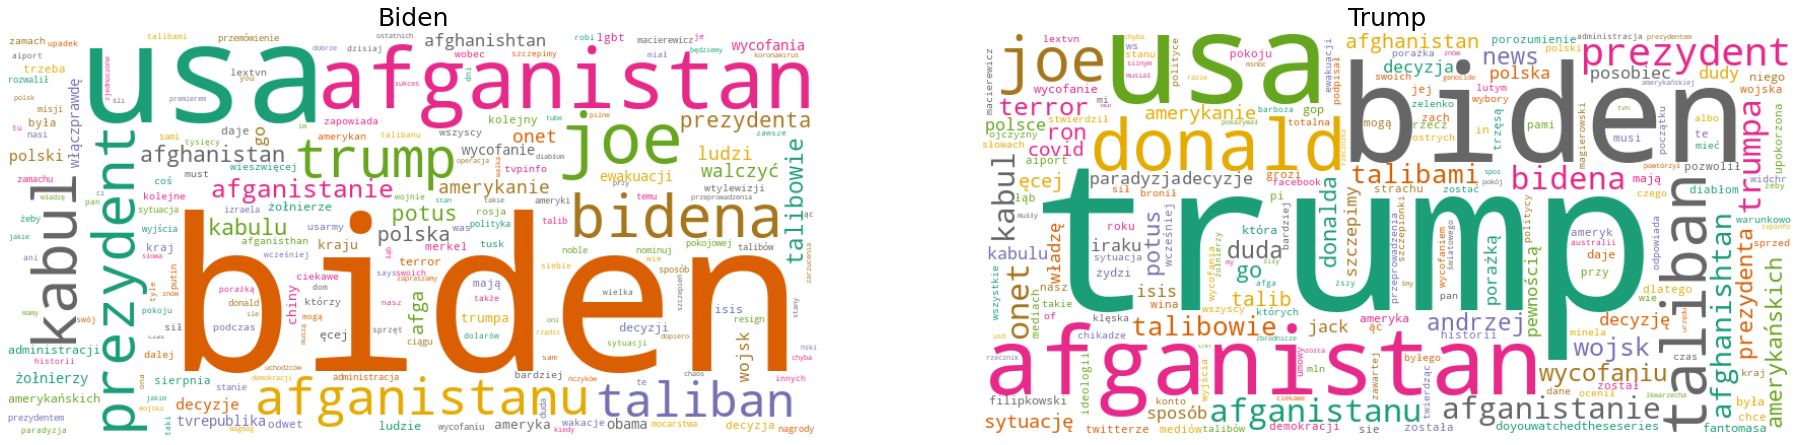

In [247]:
president = {"president": ["Biden", "Trump"], 
        "text": [biden_pl, trump_pl]}
presidents = [biden_dict, trump_dict]

for index in range(0, len(presidents)):
    
    wc.generate_from_frequencies(presidents[index])
    plt.subplot(1, 2, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(president['president'][index], fontsize=25)
    
plt.show()

## 6. Polarity & Subjectivity - plots

The final step of my project was data visualization!<br/>
Datasets for this part consisted of tweets which languages were analyzed priorly, i.e. English, Spanish, German, French and Polish.

In [36]:
biden = pd.concat([biden_en, biden_es, biden_de, biden_fr, biden_pl], axis = 'rows')
biden = biden.reset_index()
trump = pd.concat([trump_en, trump_es, trump_de, trump_fr, trump_pl], axis = 'rows')
trump = trump.reset_index()

In [49]:
plt.rcParams['figure.figsize'] = [8.0, 6.0]
plt.rcParams['figure.dpi'] = 80
plt.rcParams['savefig.dpi'] = 100

plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['figure.titlesize'] = 'medium'

Firstly, I checked whether it is a clear difference between the days and number of Biden's tweets. For all languages, two dominant areas can be observed. The first one (higher bar approximately 15.08.2021) concerns the situation in Afghanistan - the withdrawal of troops and the Taliban's seizure of power in Afghanistan. The second one (lower bar approximately 26.08.2021) could concern Biden speech about the Kabul airport attack, which killed a dozen American troops, Biden confirmation of troops evacuation till 31.08.2021 or other issues which were addressed at the 25.08.2021 conference.

array([[<AxesSubplot:title={'center':'de'}>,
        <AxesSubplot:title={'center':'en'}>],
       [<AxesSubplot:title={'center':'es'}>,
        <AxesSubplot:title={'center':'fr'}>],
       [<AxesSubplot:title={'center':'pl'}>, <AxesSubplot:>]],
      dtype=object)

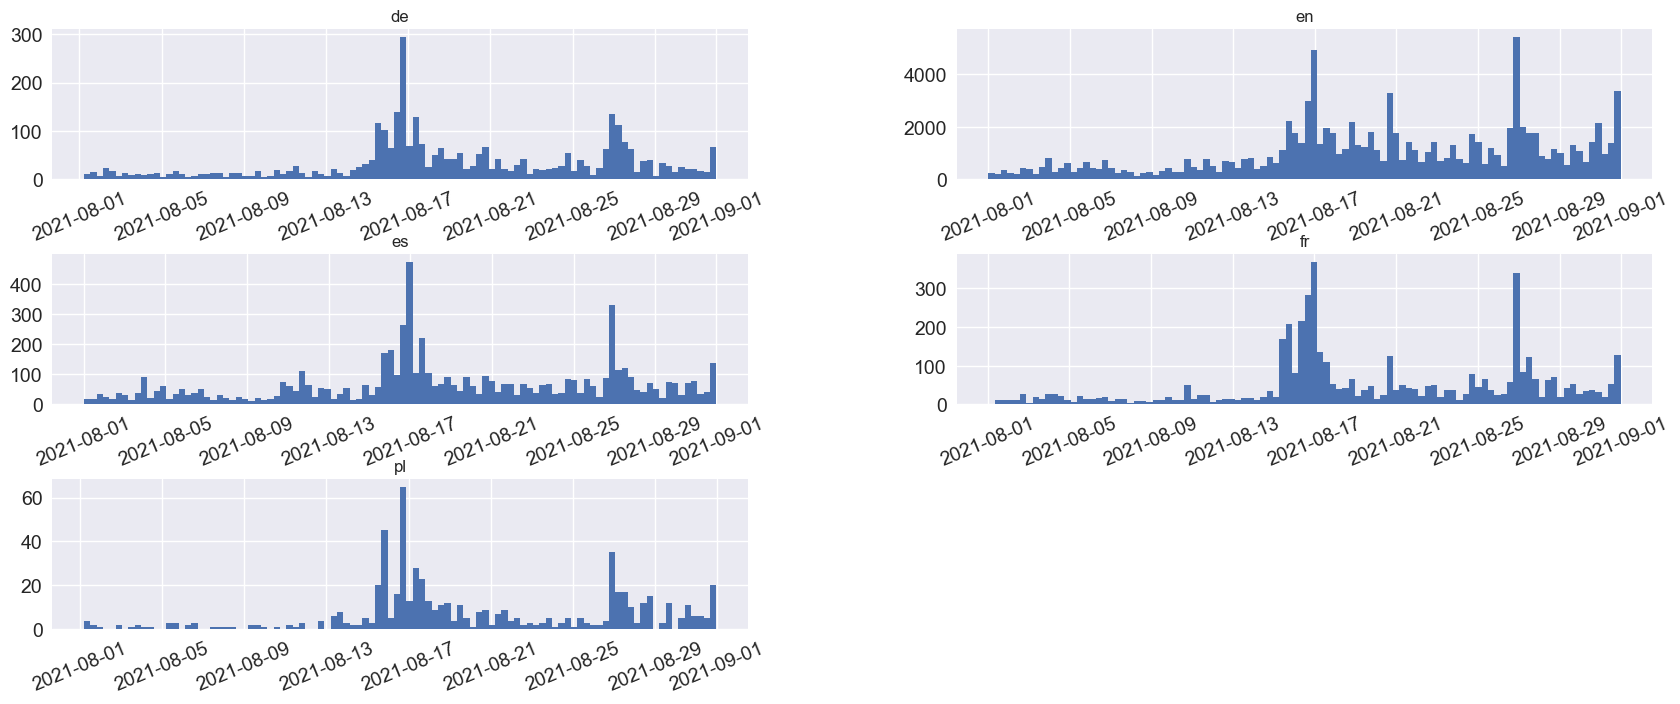

In [88]:
plt.style.use("seaborn")
biden['Datetime'].hist(bins=100, by = biden['Language'], xrot = 22.5, xlabelsize=14, ylabelsize=14, figsize=(20,8))                          

Similar (but not for all languages) observations can be spotted in Trump's dataset.

array([[<AxesSubplot:title={'center':'de'}>,
        <AxesSubplot:title={'center':'en'}>],
       [<AxesSubplot:title={'center':'es'}>,
        <AxesSubplot:title={'center':'fr'}>],
       [<AxesSubplot:title={'center':'pl'}>, <AxesSubplot:>]],
      dtype=object)

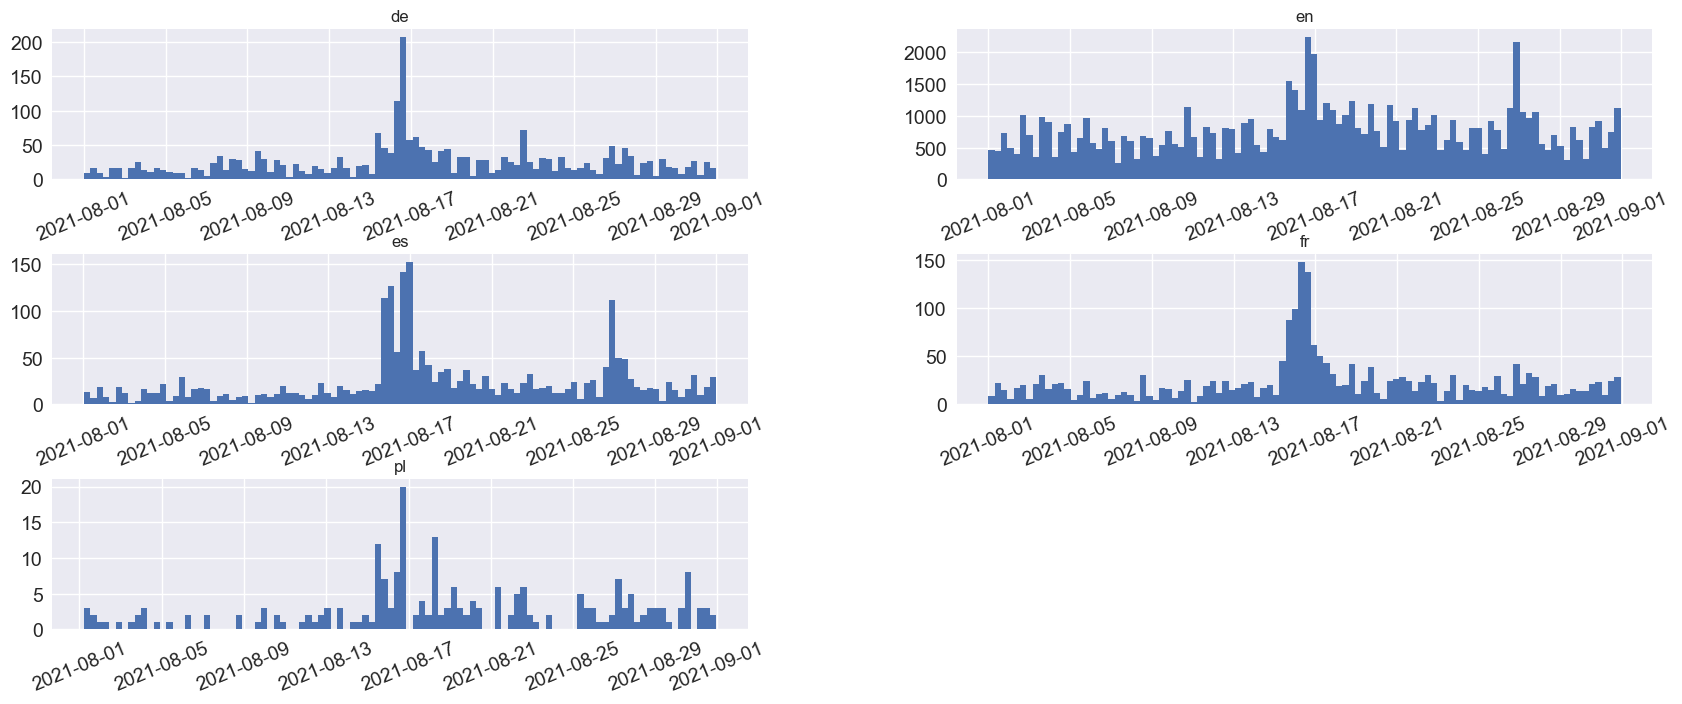

In [89]:
trump['Datetime'].hist(bins=100, by = trump['Language'], xrot = 22.5, xlabelsize=14, ylabelsize=14, figsize=(20,8))                          

Looking at *Polarity* and *Subjectivity* in Biden and Trump's datasets, a preponderance of neutral tweets (0 - *Polarity*) can be observed for both presidents. The number of tweets for *Polarity* decreases smoothly (without including point 0.0). When it comes to *Subjectivity*, the highest number of tweets can be spotted for point 0.0 (lack of *Subjectivity*). The second-largest point goes to point 0.5, and since which the number of tweets flattens.  

array([[<AxesSubplot:title={'center':'de'}>,
        <AxesSubplot:title={'center':'en'}>],
       [<AxesSubplot:title={'center':'es'}>,
        <AxesSubplot:title={'center':'fr'}>],
       [<AxesSubplot:title={'center':'pl'}>, <AxesSubplot:>]],
      dtype=object)

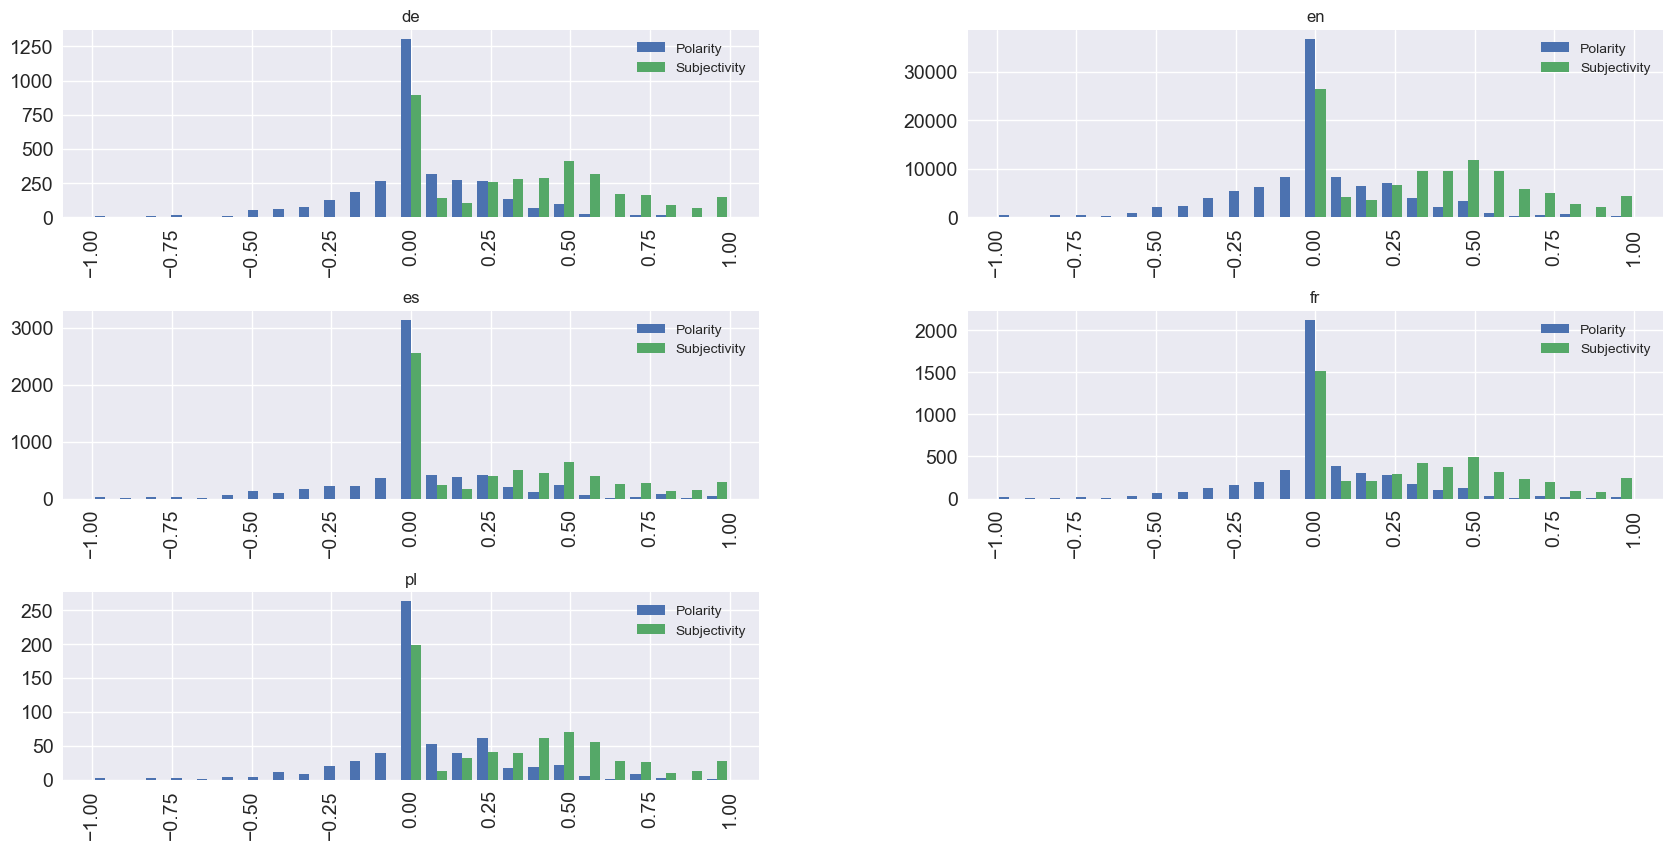

In [93]:
biden[['Polarity', 'Subjectivity']].hist(bins=25, by = biden['Language'], xlabelsize=14, ylabelsize=14,
                                         legend = True, figsize=(20,10))

array([[<AxesSubplot:title={'center':'de'}>,
        <AxesSubplot:title={'center':'en'}>],
       [<AxesSubplot:title={'center':'es'}>,
        <AxesSubplot:title={'center':'fr'}>],
       [<AxesSubplot:title={'center':'pl'}>, <AxesSubplot:>]],
      dtype=object)

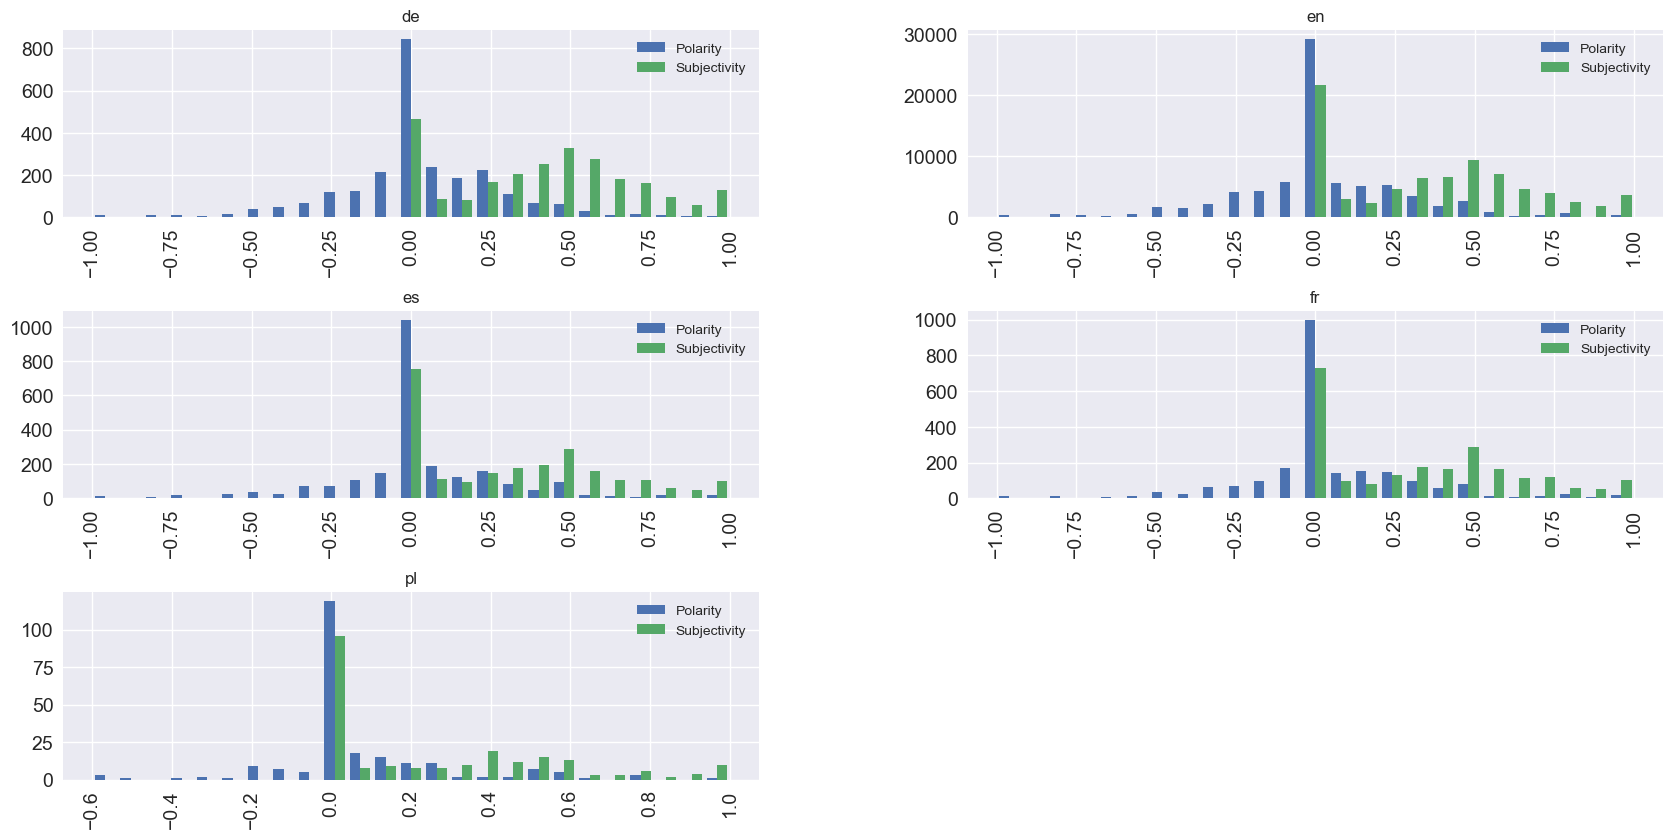

In [94]:
trump[['Polarity', 'Subjectivity']].hist(bins=25, by = trump['Language'], xlabelsize=14, ylabelsize=14,
                                         legend = True, figsize=(20,10))

Finally, the data were grouped according to hours, and the means for *polarity* and *subjectivity* were calculated. For different languages, different thresholds were set:
1. English - 6 h
2. Spanish, German, French - 12 h
3. Polish - 24 h

In [120]:
biden_plot_en = biden_en[['Polarity', 'Subjectivity']].resample('6H').mean()
biden_plot_en['Date'] = biden_plot_en.index
trump_plot_en = trump_en[['Polarity', 'Subjectivity']].resample('6H').mean()
trump_plot_en['Date'] = trump_plot_en.index


biden_plot_es = biden_es[['Polarity', 'Subjectivity']].resample('12H').mean()
biden_plot_es['Date'] = biden_plot_es.index
trump_plot_es = trump_es[['Polarity', 'Subjectivity']].resample('12H').mean()
trump_plot_es['Date'] = trump_plot_es.index


biden_plot_de = biden_de[['Polarity', 'Subjectivity']].resample('12H').mean()
biden_plot_de['Date'] = biden_plot_de.index
trump_plot_de = trump_de[['Polarity', 'Subjectivity']].resample('12H').mean()
trump_plot_de['Date'] = trump_plot_de.index


biden_plot_fr = biden_fr[['Polarity', 'Subjectivity']].resample('12H').mean()
biden_plot_fr['Date'] = biden_plot_fr.index
trump_plot_fr = trump_fr[['Polarity', 'Subjectivity']].resample('12H').mean()
trump_plot_fr['Date'] = trump_plot_fr.index


biden_plot_pl = biden_pl[['Polarity', 'Subjectivity']].resample('24H').mean()
biden_plot_pl['Date'] = biden_plot_pl.index
trump_plot_pl = trump_pl[['Polarity', 'Subjectivity']].resample('24H').mean()
trump_plot_pl['Date'] = trump_plot_pl.index

And the plots - *polarity* and *subjectivity* according to date were created.<br/>
As can be seen, the English tweets were characterized by low variance in comparison to other languages. English tweets were fluctuating around 0.0 - 0.1 for polarity and around 0.3 - 0.4 for subjectivity. The visible difference could be caused by tremendously higher share English tweets in tweets, change in meaning caused by translation and bypassing high *polarity* and *subjectivity* data in initial datasets. 



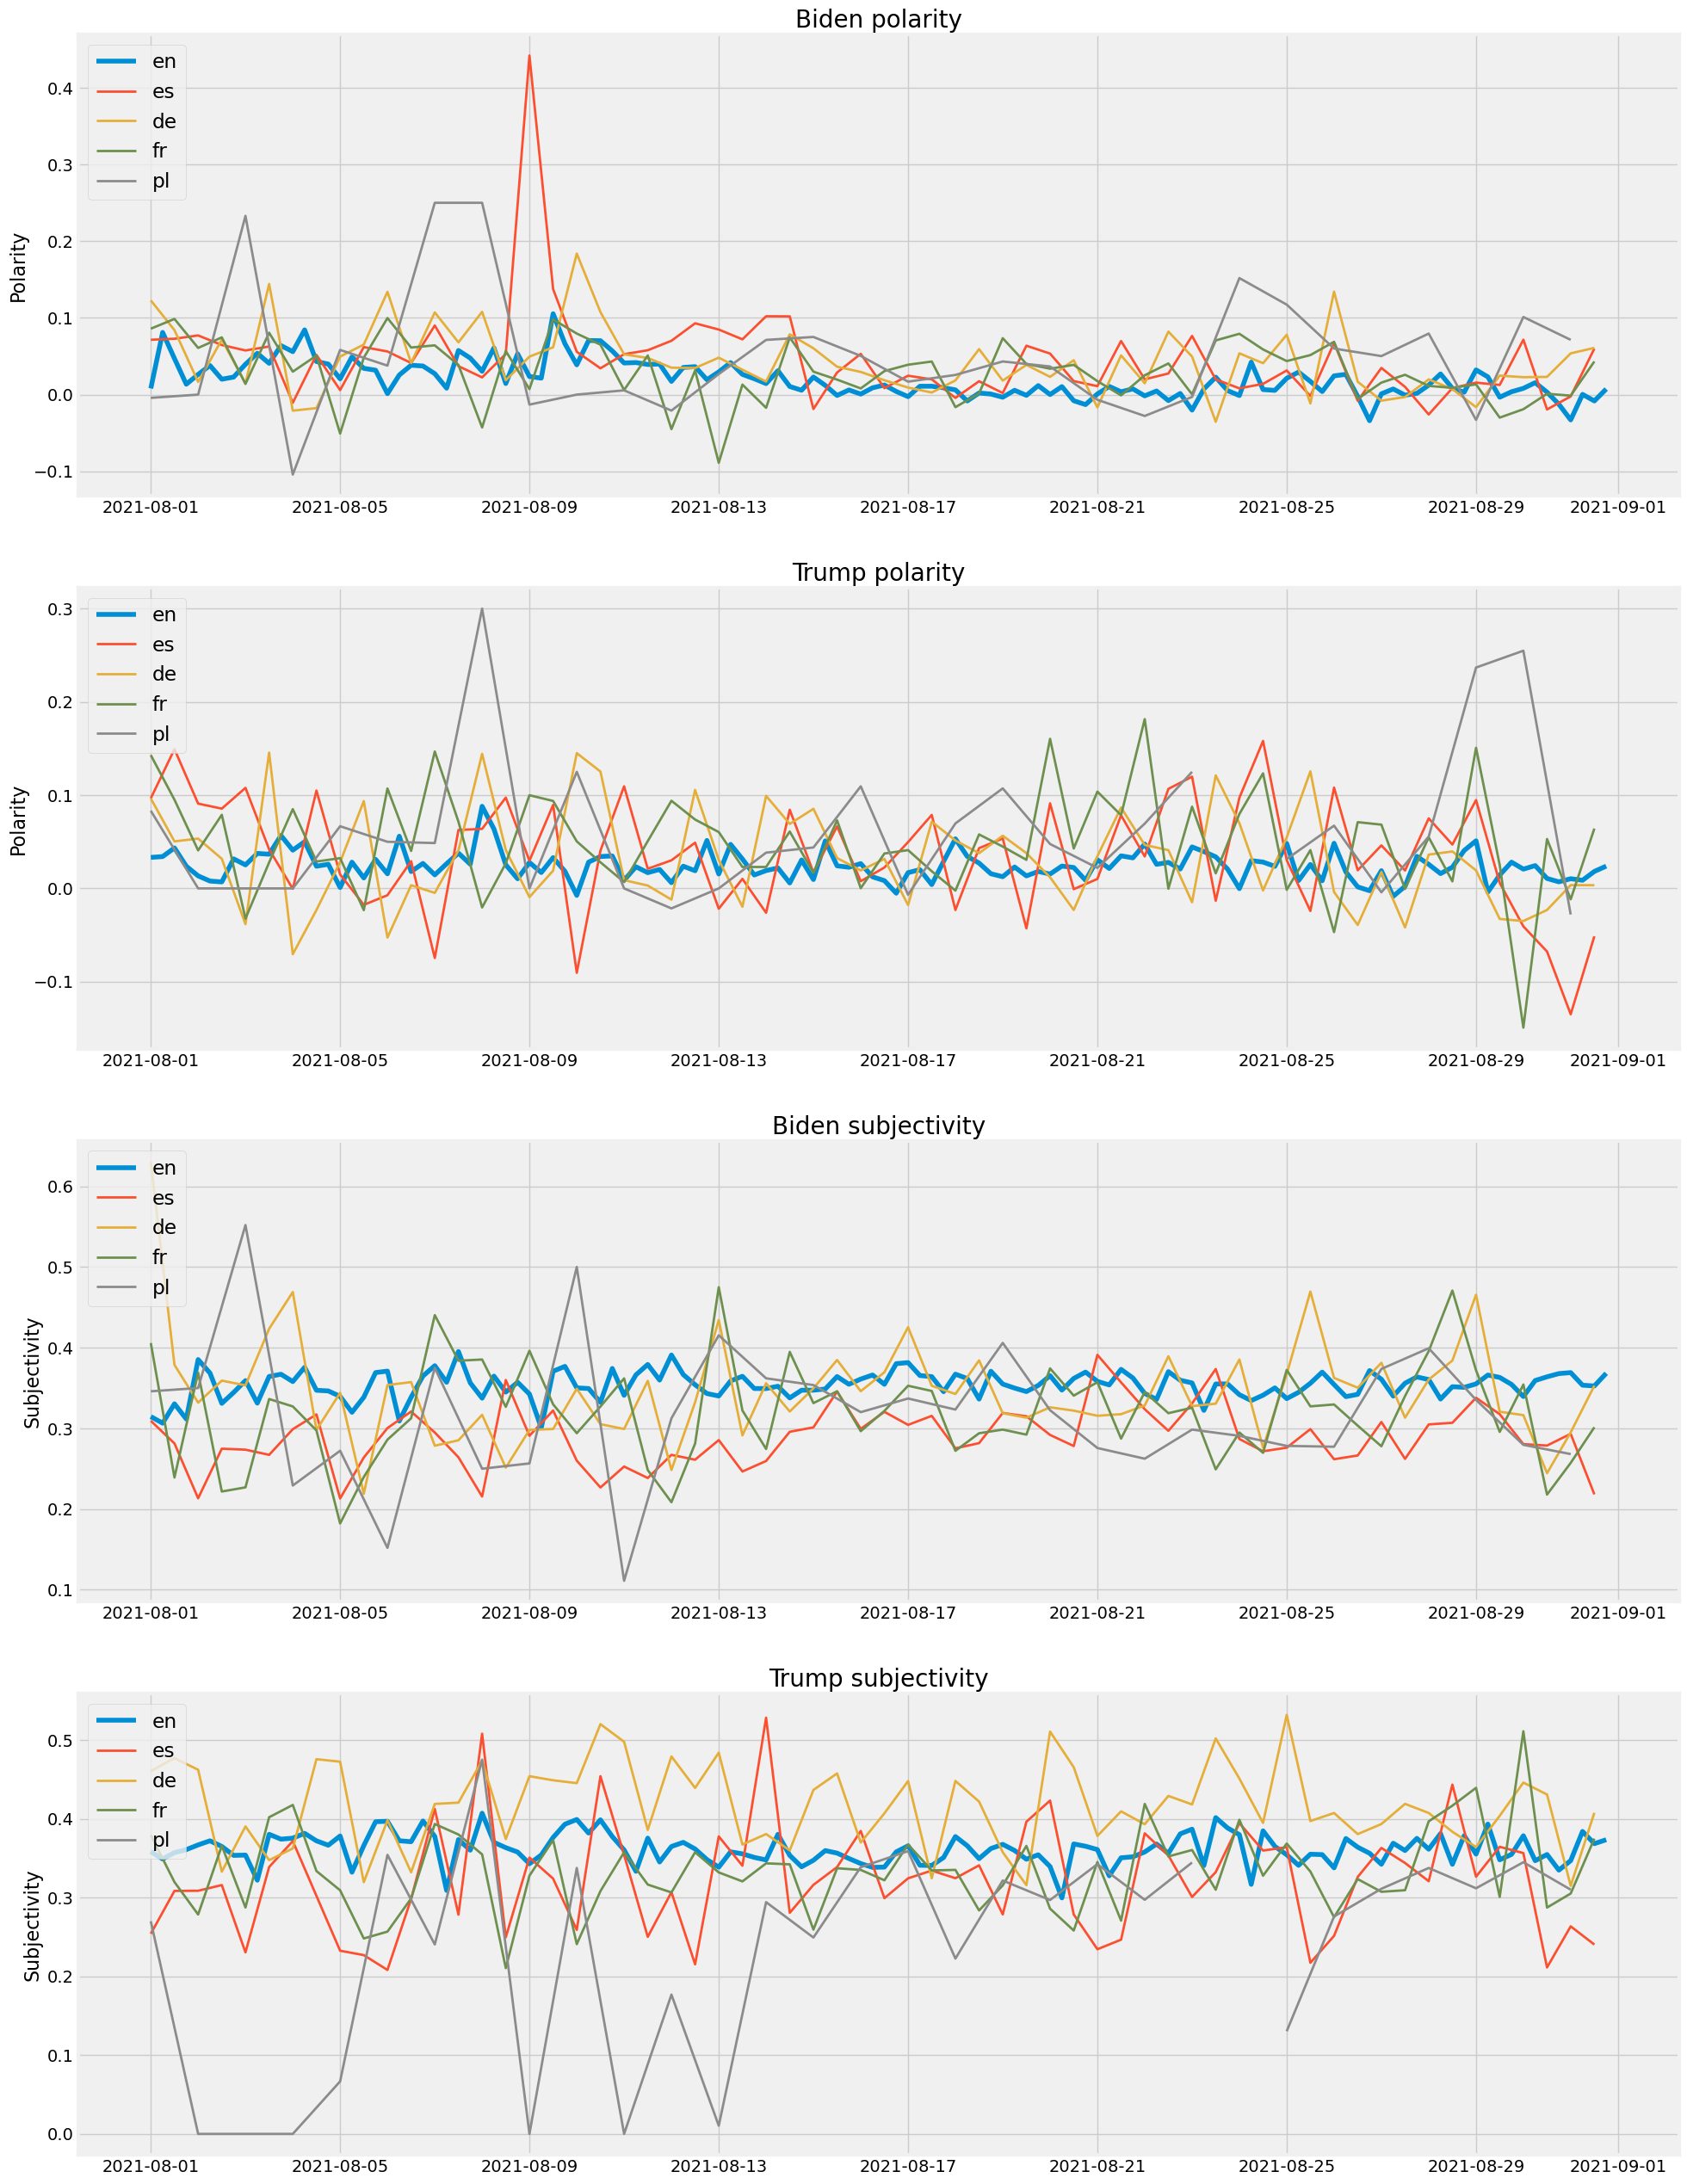

In [1226]:
dfs = [biden_plot_en, trump_plot_en, biden_plot_es, trump_plot_es, biden_plot_de, trump_plot_de,
       biden_plot_fr, trump_plot_fr, biden_plot_pl, trump_plot_pl]
names = ['Biden polarity', 'Trump polarity', 'Biden subjectivity', 'Trump subjectivity']
pol_sub = ['Polarity', 'Subjectivity']

plt.figure(figsize=(24,32))

k = 0
for i in range(0, 2):
    for j in range(0, 2):
        
        plt.style.use("fivethirtyeight")
        plt.subplot(4, 1, k+1)
        plt.plot(dfs[j]['Date'], dfs[j][pol_sub[i]], label = 'en', linewidth = 4)
        plt.plot(dfs[j+2]['Date'], dfs[j+2][pol_sub[i]], label = 'es', linewidth = 2)
        plt.plot(dfs[j+4]['Date'], dfs[j+4][pol_sub[i]], label = 'de', linewidth = 2)
        plt.plot(dfs[j+6]['Date'], dfs[j+6][pol_sub[i]], label = 'fr', linewidth = 2)
        plt.plot(dfs[j+8]['Date'], dfs[j+8][pol_sub[i]], label = 'pl', linewidth = 2)
        plt.xticks(size=14)
        plt.yticks(size=14)
        label = pol_sub[i]
        plt.ylabel(label, size = 16)
        plt.legend(loc=2, fontsize = 'large')
        name = names[k]
        plt.title(name, size = 20)
        k += 1

plt.show()

Comparing datasets at one graph for each language revealed a more insightful view of datasets. For nearly all languages, a substantial *polarity* decrease for Biden after 11.08.2021 (withdrawing US forces from Afghanistan) could be seen. That relation is clearly visible for the English dataset.

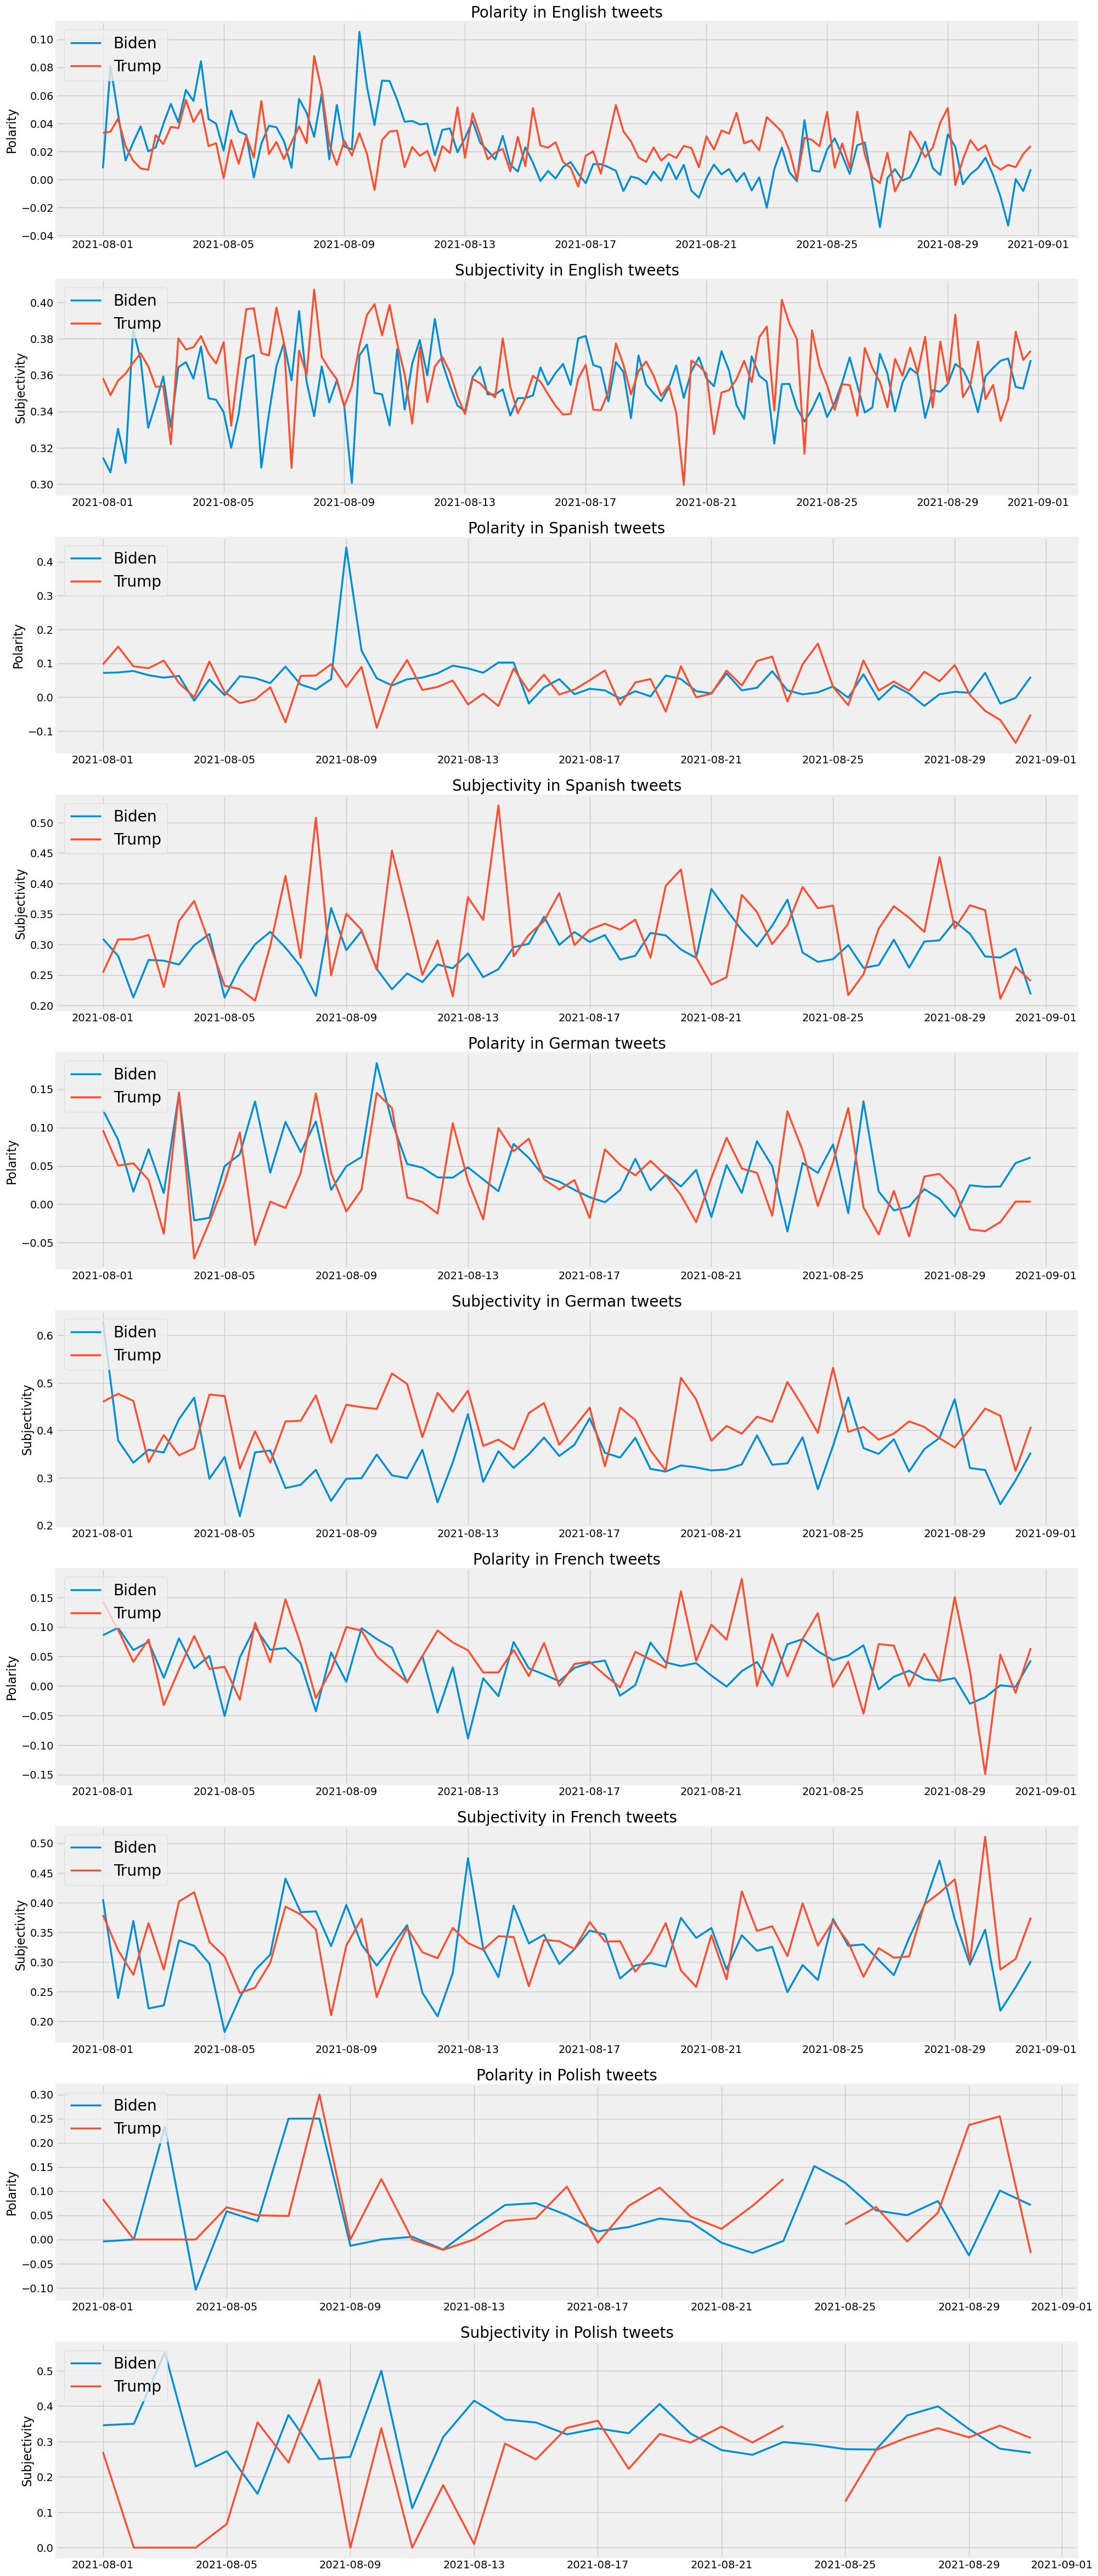

In [1230]:
names = ['English', 'English', 'Spanish', 'Spanish', 'German', 'German', 'French', 'French', 'Polish', 'Polish']

plt.figure(figsize=(24,60))

k = 0
for i in range(0, len(dfs), 2):
    for j in range(0, 2):
        
        plt.subplot(10, 1, k+1)
        plt.plot(dfs[i]['Date'], dfs[i][pol_sub[j]], label = 'Biden', linewidth = 2.5)
        plt.plot(dfs[i+1]['Date'], dfs[i+1][pol_sub[j]], label = 'Trump', linewidth = 2.5)
        plt.xticks(size=14)
        plt.yticks(size=14)
        label = pol_sub[j]
        plt.ylabel(label, size = 16)
        plt.legend(loc=2, fontsize = 'x-large')
        name = pol_sub[j] + ' in ' + names[i] + ' tweets'
        plt.title(name, size = 20)
        k += 1
    
plt.show()